In [43]:
# Import libraries and load dataset
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Read Dataset A
df = pd.read_csv("Dataset A.csv")
df.head()


,session_id,protocol_type,network_packet_size,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,TCP,298,8,1421.414372,AES,0.345368,3,Firefox,0,1
1,SID_00002,TCP,473,3,1557.996461,Blowfish,0.301569,0,Firefox,0,0
2,SID_00003,TCP,118,4,833.488965,Blowfish,0.473292,2,Unknown,0,1
3,SID_00004,UDP,805,4,601.248835,Blowfish,0.123267,0,Unknown,0,1
4,SID_00005,TCP,454,5,532.540888,AES,0.054874,1,Firefox,0,0


In [44]:
# Inspect data types, missing values and summary stats
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   protocol_type        9537 non-null   object 
 2   network_packet_size  9537 non-null   int64  
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,501.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,65.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,366.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,500.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,636.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1286.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


In [45]:
#Check class balance of the target
print(df["attack_detected"].value_counts())
print(df["attack_detected"].value_counts(normalize=True))


attack_detected
0    5273
1    4264
Name: count, dtype: int64
attack_detected
0    0.552899
1    0.447101
Name: proportion, dtype: float64


In [46]:
#Drop session_id (identifier only)
df = df.drop(columns=["session_id"])

In [47]:
# Handle missing values in encryption_used
df["encryption_used"] = df["encryption_used"].fillna("Unknown")

In [48]:
# One-hot encode categorical features (your original approach)
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.shape, df_encoded.columns[:15]

((9537, 15),
 Index(['network_packet_size', 'login_attempts', 'session_duration',
        'ip_reputation_score', 'failed_logins', 'unusual_time_access',
        'attack_detected', 'protocol_type_TCP', 'protocol_type_UDP',
        'encryption_used_Blowfish', 'encryption_used_Unknown',
        'browser_type_Edge', 'browser_type_Firefox', 'browser_type_Safari',
        'browser_type_Unknown'],
       dtype='object'))

In [49]:
# Train/test split (80/20)
X = df_encoded.drop("attack_detected", axis=1)
y = df_encoded["attack_detected"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape

((7629, 14), (1908, 14))

In [50]:
# Scale numerical features (fit scaler on TRAIN only to avoid leakage)

# include unusual_time_access as numeric too
num_cols = [
    "network_packet_size",
    "login_attempts",
    "session_duration",
    "ip_reputation_score",
    "failed_logins",
    "unusual_time_access",
]

scaler = StandardScaler()

# Work on copies so we keep X_train/X_test as DataFrames
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit on train, transform both
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("\nClass balance before SMOTE:")
print(y_train.value_counts())

print("\nClass balance after SMOTE:")
print(y_train_res.value_counts())


Class balance before SMOTE:
attack_detected
0    4218
1    3411
Name: count, dtype: int64

Class balance after SMOTE:
attack_detected
0    4218
1    4218
Name: count, dtype: int64


In [52]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
)

log_reg.fit(X_train_res, y_train_res)
y_pred_log = log_reg.predict(X_test_scaled)

acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
cm_log = confusion_matrix(y_test, y_pred_log)

print("Logistic Regression Results")
print("---------------------------")
print("Accuracy:", acc_log)
print("Precision:", prec_log)
print("Recall:", rec_log)
print("F1 Score:", f1_log)
print("\nConfusion Matrix:\n", cm_log)
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Logistic Regression Results
---------------------------
Accuracy: 0.7196016771488469
Precision: 0.6790540540540541
Recall: 0.7069167643610785
F1 Score: 0.6927053417576106

Confusion Matrix:
 [[770 285]
 [250 603]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74      1055
           1       0.68      0.71      0.69       853

    accuracy                           0.72      1908
   macro avg       0.72      0.72      0.72      1908
weighted avg       0.72      0.72      0.72      1908



In [53]:
#Random Forest training
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Results")
print("----------------------")
print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1 Score:", f1_rf)
print("\nConfusion Matrix:\n", cm_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Results
----------------------
Accuracy: 0.8841719077568134
Precision: 0.9876543209876543
Recall: 0.7502930832356389
F1 Score: 0.8527648234510327

Confusion Matrix:
 [[1047    8]
 [ 213  640]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      1055
           1       0.99      0.75      0.85       853

    accuracy                           0.88      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.88      0.88      1908



In [54]:
# Random Forest feature importance
importances = rf.feature_importances_

feature_importance = pd.DataFrame(
    {"feature": X_train_scaled.columns, "importance": importances}
).sort_values(by="importance", ascending=False)

feature_importance.head(10)


,feature,importance
4,failed_logins,0.280013
3,ip_reputation_score,0.222658
1,login_attempts,0.219113
2,session_duration,0.102388
0,network_packet_size,0.095783
13,browser_type_Unknown,0.028695
5,unusual_time_access,0.008307
8,encryption_used_Blowfish,0.007193
11,browser_type_Firefox,0.007153
9,encryption_used_Unknown,0.006852


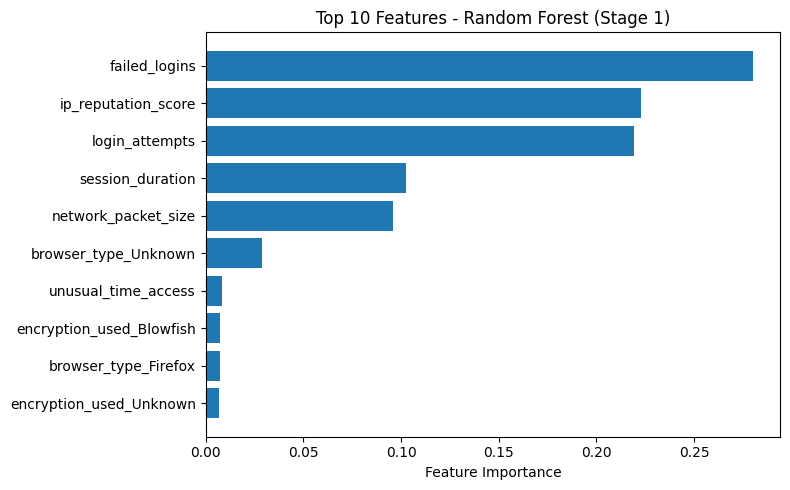

In [55]:
# Plot top 10 importances
top_n = 10
top_features = feature_importance.head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(top_features["feature"], top_features["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 10 Features - Random Forest (Stage 1)")
plt.tight_layout()
plt.show()

In [56]:
# SVM with RBF kernel
from sklearn.svm import SVC

svm_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=RANDOM_STATE,
)

svm_model.fit(X_train_res, y_train_res)
y_pred_svm = svm_model.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print("SVM Results")
print("-----------")
print("Accuracy:", acc_svm)
print("Precision:", prec_svm)
print("Recall:", rec_svm)
print("F1 Score:", f1_svm)
print("\nConfusion Matrix:\n", cm_svm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

SVM Results
-----------
Accuracy: 0.8742138364779874
Precision: 0.9581464872944694
Recall: 0.7514654161781946
F1 Score: 0.8423127463863338

Confusion Matrix:
 [[1027   28]
 [ 212  641]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      1055
           1       0.96      0.75      0.84       853

    accuracy                           0.87      1908
   macro avg       0.89      0.86      0.87      1908
weighted avg       0.89      0.87      0.87      1908



In [57]:
#Baseline XGBoost classifier
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
)

xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n=== XGBoost Results ===")
print("Accuracy:", acc_xgb)
print("Precision:", prec_xgb)
print("Recall:", rec_xgb)
print("F1 Score:", f1_xgb)
print("\nConfusion Matrix:\n", cm_xgb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))



=== XGBoost Results ===
Accuracy: 0.8867924528301887
Precision: 1.0
Recall: 0.7467760844079718
F1 Score: 0.8550335570469799

Confusion Matrix:
 [[1055    0]
 [ 216  637]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.86       853

    accuracy                           0.89      1908
   macro avg       0.92      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908



In [58]:
# Deep Learning with scikit-learn MLPClassifier
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=RANDOM_STATE,
    early_stopping=True,
)

mlp_clf.fit(X_train_res, y_train_res)
y_pred_mlp = mlp_clf.predict(X_test_scaled)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp)
rec_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

print("MLPClassifier (Neural Network) Results")
print("--------------------------------------")
print("Accuracy:", acc_mlp)
print("Precision:", prec_mlp)
print("Recall:", rec_mlp)
print("F1 Score:", f1_mlp)
print("\nConfusion Matrix:\n", cm_mlp)
print("\nClassification Report:\n", classification_report(y_test, y_pred_mlp))

MLPClassifier (Neural Network) Results
--------------------------------------
Accuracy: 0.8736897274633124
Precision: 0.9594594594594594
Recall: 0.7491207502930832
F1 Score: 0.8413429888084266

Confusion Matrix:
 [[1028   27]
 [ 214  639]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      1055
           1       0.96      0.75      0.84       853

    accuracy                           0.87      1908
   macro avg       0.89      0.86      0.87      1908
weighted avg       0.89      0.87      0.87      1908



In [59]:
# Summary of all models' performance
results_summary = pd.DataFrame(
    [
        ["Logistic Regression", acc_log, prec_log, rec_log, f1_log],
        ["Random Forest", acc_rf, prec_rf, rec_rf, f1_rf],
        ["SVM (RBF)", acc_svm, prec_svm, rec_svm, f1_svm],
        ["XGBoost", acc_xgb, prec_xgb, rec_xgb, f1_xgb],
        ["MLP (Neural Net)", acc_mlp, prec_mlp, rec_mlp, f1_mlp],
    ],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1"],
).set_index("Model")

results_summary

,Accuracy,Precision,Recall,F1
Model,,,,
Logistic Regression,0.719602,0.679054,0.706917,0.692705
Random Forest,0.884172,0.987654,0.750293,0.852765
SVM (RBF),0.874214,0.958146,0.751465,0.842313
XGBoost,0.886792,1.000000,0.746776,0.855034
MLP (Neural Net),0.873690,0.959459,0.749121,0.841343


In [60]:
# ENSEMBLE VOTING 
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svm', svm_model)],
    voting='soft', n_jobs=-1
)

ensemble.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble.predict(X_test_scaled)

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
rec_ensemble = recall_score(y_test, y_pred_ensemble)

print("=== ENSEMBLE (RF + XGB + SVM) ===")
print("Accuracy:", acc_ensemble)
print("F1 Score:", f1_ensemble)
print("Recall:", rec_ensemble)



=== ENSEMBLE (RF + XGB + SVM) ===
Accuracy: 0.8857442348008385
F1 Score: 0.8536912751677852
Recall: 0.7456037514654161


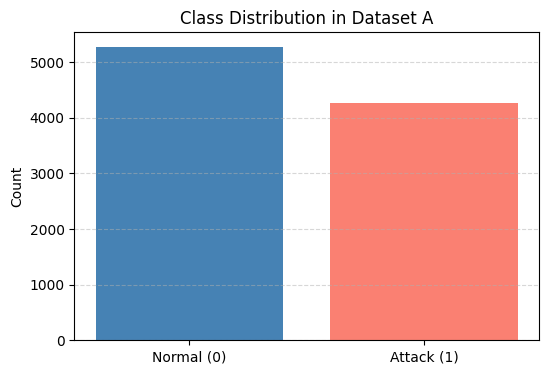

In [61]:
# Visualisation: Class distribution
import matplotlib.pyplot as plt

class_counts = y.value_counts()

plt.figure(figsize=(6,4))
plt.bar(class_counts.index, class_counts.values, color=['steelblue', 'salmon'])
plt.xticks([0,1], ["Normal (0)", "Attack (1)"])
plt.ylabel("Count")
plt.title("Class Distribution in Dataset A")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


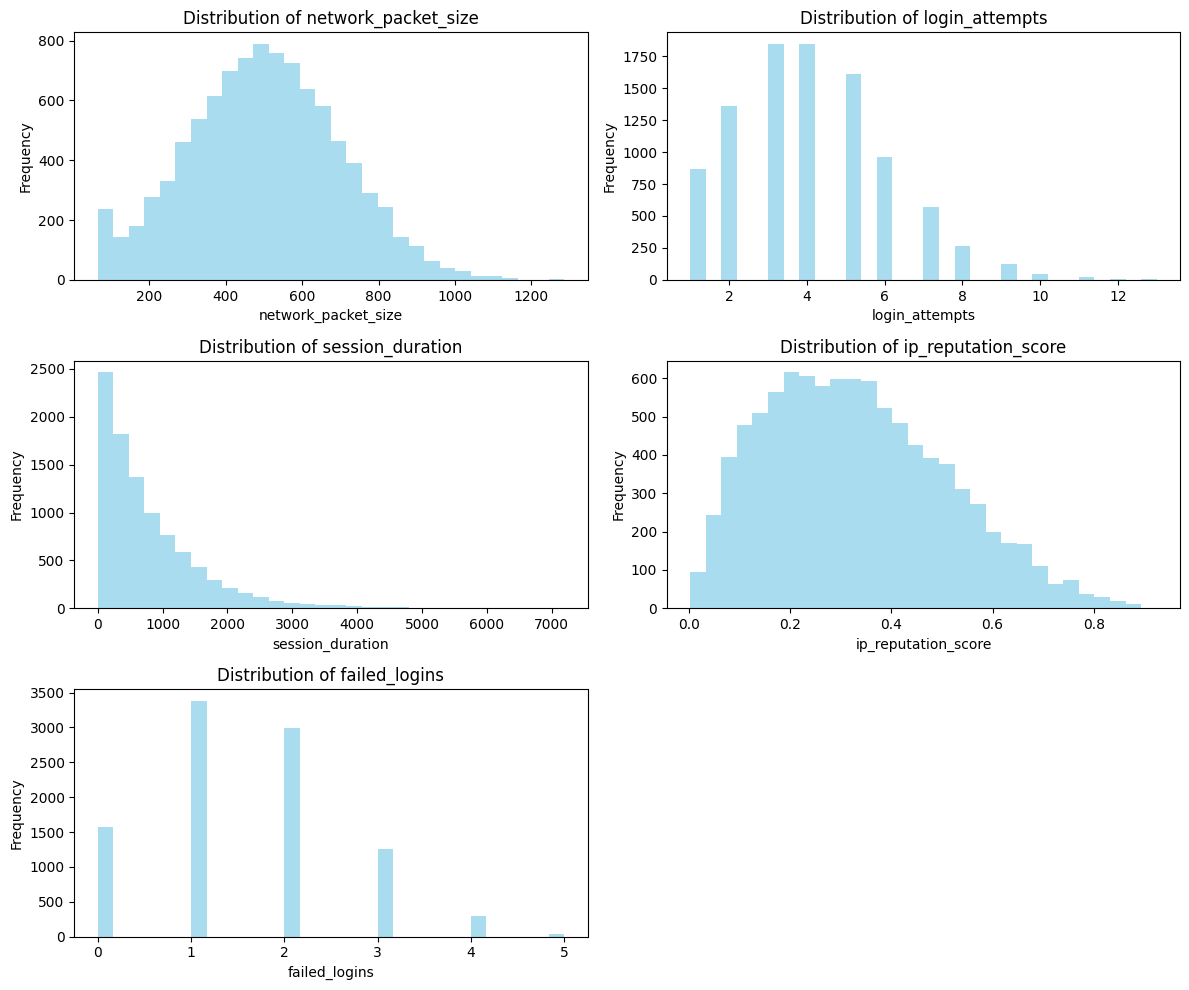

In [62]:
# Visualisation: Histograms of numeric features
num_cols_to_plot = [
    "network_packet_size",
    "login_attempts",
    "session_duration",
    "ip_reputation_score",
    "failed_logins",
]

plt.figure(figsize=(12, 10))

for i, col in enumerate(num_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    plt.hist(df[col], bins=30, alpha=0.7, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


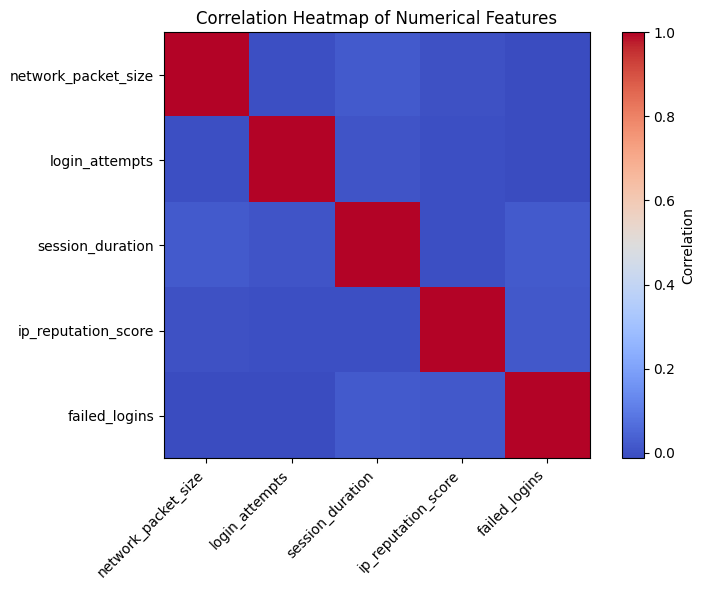

In [63]:
# Visualisation: Correlation heatmap
import numpy as np
import matplotlib.pyplot as plt

corr = df[num_cols_to_plot].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')

plt.xticks(range(len(num_cols_to_plot)), num_cols_to_plot, rotation=45, ha='right')
plt.yticks(range(len(num_cols_to_plot)), num_cols_to_plot)

plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

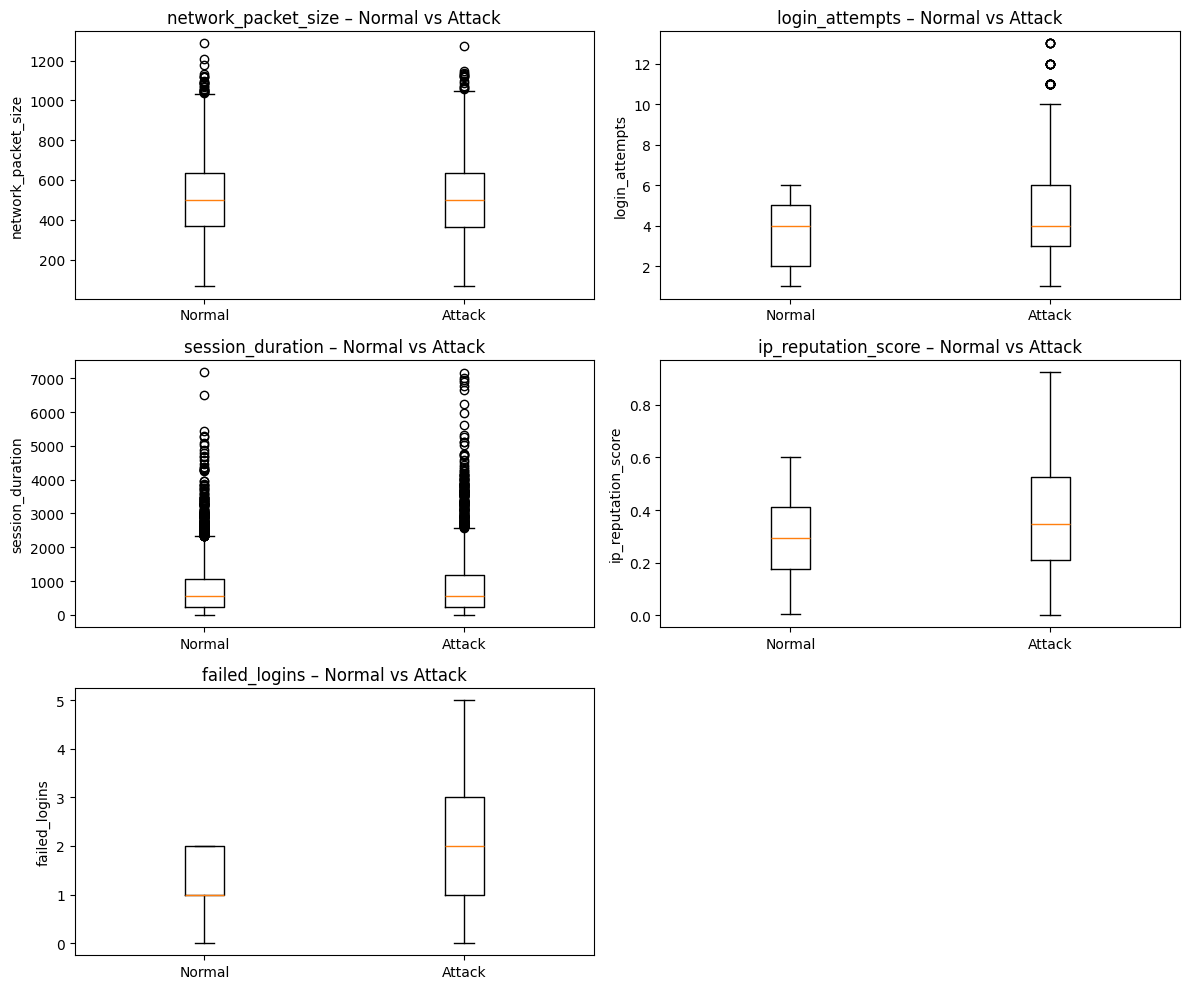

In [64]:
# Visualisation: Boxplots grouped by label
plt.figure(figsize=(12, 10))

for i, col in enumerate(num_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    plt.boxplot(
        [df[df['attack_detected']==0][col], df[df['attack_detected']==1][col]],
       tick_labels=["Normal", "Attack"]
    )
    plt.title(f"{col} – Normal vs Attack")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

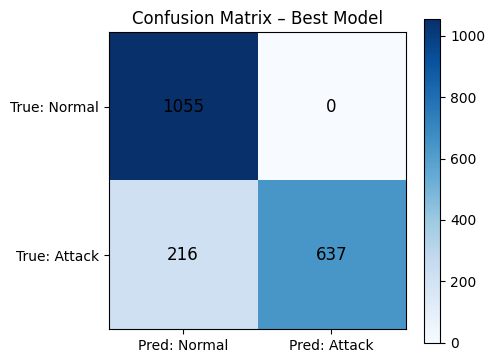

In [65]:
# Visualisation: Confusion Matrix for Best Model
best_cm = cm_xgb   # Or whichever model you want to visualise (rf, svm, mlp)

plt.figure(figsize=(5,4))
plt.imshow(best_cm, cmap='Blues')
plt.title("Confusion Matrix – Best Model")
plt.colorbar()

# Label axes
plt.xticks([0,1], ["Pred: Normal", "Pred: Attack"])
plt.yticks([0,1], ["True: Normal", "True: Attack"])

# Add text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, best_cm[i,j], ha='center', va='center', color='black', fontsize=12)

plt.tight_layout()
plt.show()

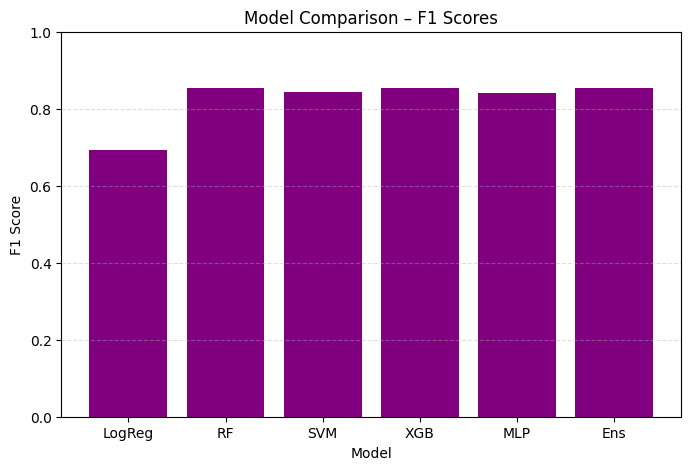

In [68]:
# Visualisation: Model performance comparison
models = ["LogReg", "RF", "SVM", "XGB", "MLP", "Ens"]
f1_scores = [f1_log, f1_rf, f1_svm, f1_xgb, f1_mlp, f1_ensemble]

plt.figure(figsize=(8,5))
plt.bar(models, f1_scores, color='purple')
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("Model Comparison – F1 Scores")
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

In [67]:
import joblib
joblib.dump(xgb_best, "stage1_xgboost_tuned.pkl")
joblib.dump(scaler, "stage1_scaler.pkl")

['stage1_scaler.pkl']